In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support

from clulib import parse_data, data_path, draw_predictions, make_data

In [2]:
matplotlib.rcParams['font.size'] = 14

In [3]:
energy = 3000
use_models = True
npdata = True
if npdata:
    data = np.load(f'npy/e{energy}.npz')
    pidata, gadata = data['pione'], data['gaone']
else:
    pidata, _, _ = parse_data('pi0', energy, data_path())
    gadata, _, _ = parse_data('gamma', energy, data_path())
print(pidata.shape, gadata.shape)

(82891, 28) (80048, 28)


## Preprocess data

### Data format

Each cluster is represented by 28 numbers:
 * Flattened 5x5 energy depositions in crystals around the cluster center. The cluster center is defined as clusted with maximal energy deposition
 * Sum of energy deposition beyond the inner 5x5 area
 * z and phi index of the center cluster (not used!)
 
### Data preprocessing
 * Last two values are dropped
 * Other values are normalized so that sum of values equal unity

In [4]:
X_train, X_test, y_train, y_test = make_data(pidata, gadata)
X_train.shape

(130351, 26)

# Baseline: linear regressor

Train linear regressor

In [5]:
%%time
linear_model_fname = f'models/linear_{energy}.joblib'
if use_models and os.path.isfile(linear_model_fname):
    reg = joblib.load(linear_model_fname)
else:
    reg = LinearRegression().fit(X_train, y_train)
    joblib.dump(reg, linear_model_fname)
reg.score(X_test, y_test)

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 4.81 ms


0.6560254895792479

In [6]:
linear_prob = reg.predict(X_test)
linear_pred = linear_prob > 0.75
roc_auc_score(y_test, linear_prob)

0.9848216752168661

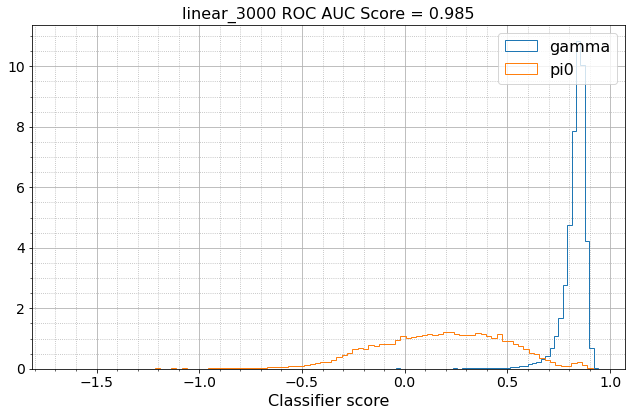

In [7]:
draw_predictions(linear_prob, y_test, key=f'linear_{energy}')

In [8]:
accuracy_score(y_test, linear_pred)

0.9482017920707009

In [9]:
precision_recall_fscore_support(y_test, linear_pred)

(array([0.92250543, 0.97799867]),
 array([0.97984703, 0.91584957]),
 array([0.95031202, 0.94590437]),
 array([16474, 16114]))

## 1st classifier: neural net

Train neural net classifier with one hidden layer of `100` neurons with 300 epochs

In [10]:
%%time
mlp_model_fname = f'models/mlp_{energy}.joblib'
if use_models and os.path.isfile(mlp_model_fname):
    clf = joblib.load(mlp_model_fname)
else:
    clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
    joblib.dump(clf, mlp_model_fname)
clf.score(X_test, y_test)

CPU times: user 803 ms, sys: 178 ms, total: 981 ms
Wall time: 289 ms


0.9859150607585614

In [11]:
mlp_prob = clf.predict_proba(X_test)
mlp_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.9859150607585614

In [12]:
roc_auc_score(y_test, mlp_prob[:, 1])

0.9893770233872535

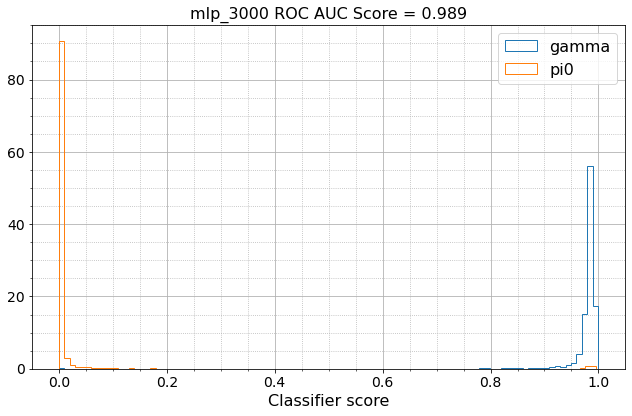

In [13]:
draw_predictions(mlp_prob[:, 1], y_test, key=f'mlp_{energy}')

In [14]:
accuracy_score(y_test, mlp_pred)

0.9859150607585614

In [15]:
precision_recall_fscore_support(y_test, mlp_pred)

(array([0.9950541 , 0.97690855]),
 array([0.97699405, 0.99503537]),
 array([0.98594138, 0.98588865]),
 array([16474, 16114]))

## 2nd classifier: Gradient Boosting

In [16]:
%%time
gbc_model_fname = f'models/gbc_{energy}.joblib'
if use_models and os.path.isfile(gbc_model_fname):
    gbc = joblib.load(gbc_model_fname)
else:
    gbc = GradientBoostingClassifier(random_state=9).fit(X_train, y_train)
    joblib.dump(gbc, gbc_model_fname)
gbc.score(X_test, y_test)

CPU times: user 91.8 ms, sys: 0 ns, total: 91.8 ms
Wall time: 92.4 ms


0.974469129741009

In [17]:
gbc_prob = gbc.predict_proba(X_test)
gbc_pred = gbc.predict(X_test)
roc_auc_score(y_test, gbc_prob[:, 1])

0.9883000803173227

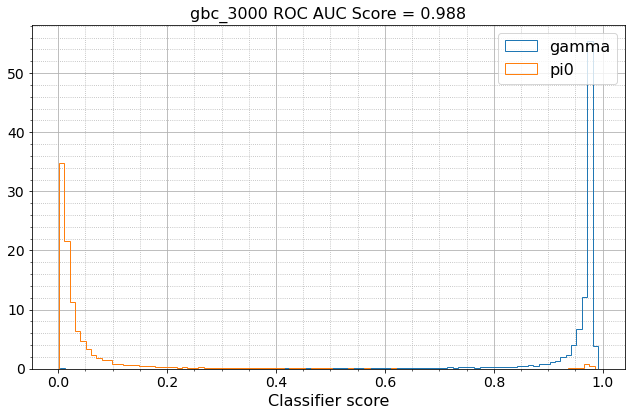

In [18]:
draw_predictions(gbc_prob[:, 1], y_test, key=f'gbc_{energy}')

In [19]:
accuracy_score(y_test, gbc_pred)

0.974469129741009

In [20]:
precision_recall_fscore_support(y_test, gbc_pred)

(array([0.97630938, 0.9726002 ]),
 array([0.97310914, 0.9758595 ]),
 array([0.97470663, 0.97422712]),
 array([16474, 16114]))

## 3rd classifier: XGBoost

In [21]:
import xgboost as xgb

In [22]:
param = {'max_depth':3, 'eta':0.5, 'objective':'binary:logistic'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [23]:
%%time
xgb_model_fname = f'models/xgb_{energy}.joblib'
if use_models and os.path.isfile(xgb_model_fname):
    bst = joblib.load(xgb_model_fname)
else:
    bst = xgb.train(param, dtrain, num_boost_round=100)
    joblib.dump(bst, xgb_model_fname)

CPU times: user 40.8 ms, sys: 142 µs, total: 40.9 ms
Wall time: 11.2 ms


In [24]:
xgb_prob = bst.predict(dtest)
xgb_pred = xgb_prob > 0.5

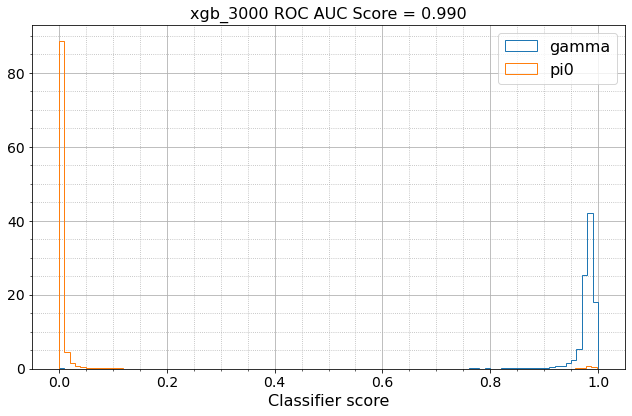

In [25]:
draw_predictions(xgb_prob, y_test, key=f'xgb_{energy}')

In [26]:
roc_auc_score(y_test, xgb_prob)

0.989920794173371

In [27]:
accuracy_score(y_test, xgb_pred)

0.9862832944642199

In [28]:
precision_recall_fscore_support(y_test, xgb_pred)

(array([0.99395919, 0.978674  ]),
 array([0.9788151 , 0.99391833]),
 array([0.98632902, 0.98623726]),
 array([16474, 16114]))

## Cluster examples

In [29]:
misses = np.nonzero((xgb_prob > 0.99) & (y_test==0))[0]
misses.size

48

In [30]:
from clulib import draw_cluster_local

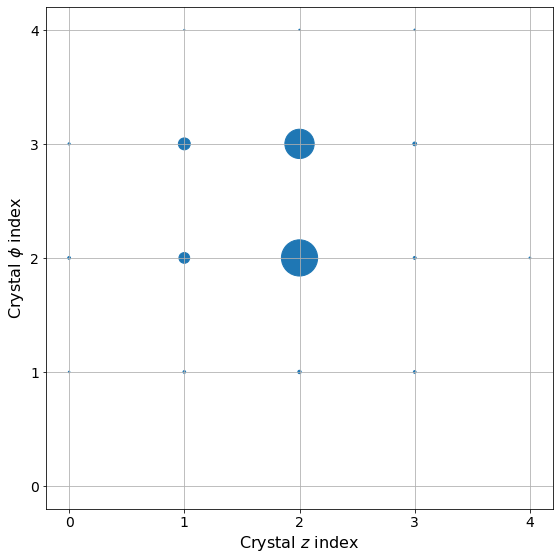

In [31]:
draw_cluster_local(X_test[misses[0]], f'false_gam_{energy}')

In [32]:
confident_pi0 = np.nonzero((xgb_prob < 0.01) & (y_test==0))[0]
confident_pi0.size

14556

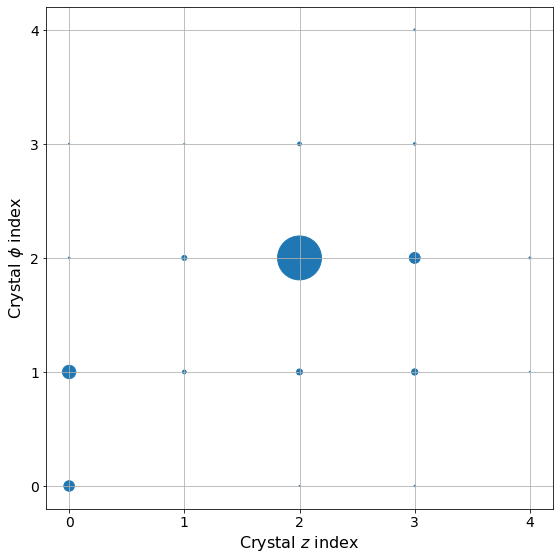

In [33]:
draw_cluster_local(X_test[confident_pi0[0]], f'confident_pi0_{energy}')

In [34]:
confident_gam = np.nonzero((xgb_prob > 0.99) & (y_test==1))[0]
confident_gam.size

2737

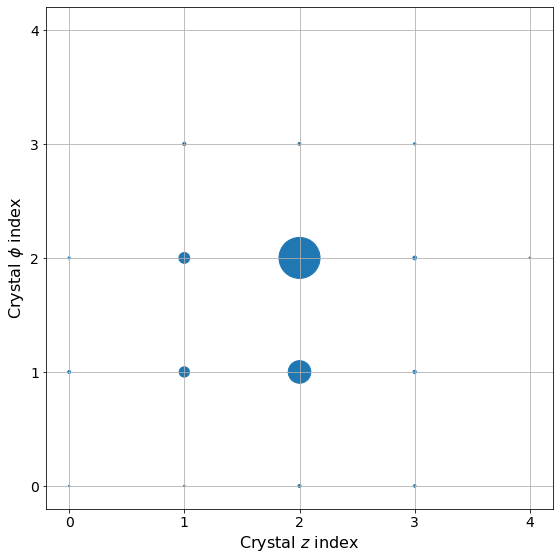

In [35]:
draw_cluster_local(X_test[confident_gam[0]], f'confident_gam_{energy}')